In [1]:
import numpy as np
import scipy
import scipy.fft
import soundfile as sf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
def quantize(A, nlevels):
    """
    Quantize array A to nlevels.
    
    Returns the quantized values and the quantization limits.
    """
    smallest = np.min(A)
    largest = np.max(A)
    bins = np.linspace(smallest, largest, nlevels+1)
    bins[-1] = np.nextafter(bins[-1], np.infty)
    return np.digitize(A, bins), (smallest, largest)

def unquantize(Q, nlevels, limits):
    """
    Decoder of quantize. Takes as input the quantized output, the
    number of levels and the quantization limits.
    
    Returns the unquantized array.
    """
    smallest, largest = limits
    bins = np.linspace(smallest, largest, nlevels+1)
    vals = (bins[1:]+bins[:-1]) / 2
    return vals[Q-1]

def dct(arr, sr):
    '''
    compute dct, return the frequencies (computing using the sample rate) and the dct
    '''
    return np.arange(len(arr))*sr/2/len(arr), scipy.fft.dct(arr, norm='ortho')

def idct(dct_arr):
    '''
    inverse dct
    '''
    return scipy.fft.idct(dct_arr,norm='ortho')

def lowpass_dct(dct_arr, dct_freqs, frequency_cutoff):
    """
    Apply lowpass filter on the dct array. Sets the frequencies above a cutoff to zero.
    Takes as input the dct array and the dct frequencies returned by the dct function above,
    and the frequency cutoff.
    
    Returns the lowpass filtered dct array (after truncating the zeroed out part).
    """
    # find index where frequency exceeds cutoff
    if frequency_cutoff is None:
        cutoff_index = len(dct_freqs)
    else:
        cutoff_index = np.where(dct_freqs > frequency_cutoff)[0]
        if len(cutoff_index) == 0:
            cutoff_index = len(dct_freqs)
        else:
            cutoff_index = cutoff_index[0]
    
    # apply cutoff
    dct_arr = dct_arr[:cutoff_index]

    return dct_arr

def inv_lowpass_dct(lowpassed_dct_arr, dct_arr_size):
    """
    Decoder of lowpass_dct, simply sets the higher frequencies to zero.
    """
    dct_arr = np.zeros(dct_arr_size)
    dct_arr[:len(lowpassed_dct_arr)] = lowpassed_dct_arr
    return dct_arr

def compute_mse(original, reconstruction):
    """
    Compute the mean square error.
    """
    return ((original - reconstruction)**2).mean()

def load_wav_audio(filepath):
    '''
    load wav audio as float np array and return the array and the sample rate
    Checks that audio is mono
    '''
    audio_arr, audio_sr = sf.read(filepath)
    assert len(audio_arr.shape) == 1 # mono
    return audio_arr, audio_sr
    
def save_wav_audio(filepath, audio_arr, audio_sr):
    '''
    save wav audio to file
    '''
    sf.write(filepath,audio_arr,audio_sr)

def compute_entropy(quantized_arr):
    """Compute empirical entropy for quantized_arr
    """
    return scipy.stats.entropy(np.bincount(quantized_arr))
    
def evaluate_dct_lowpass_quantization(audio_arr, audio_sr, frequency_cutoff, n_quantization_levels):
    """
    Evaluate quantization of lowpassed dct.
    Returns:
            reconstructed audio array
            compression rate (kilobits per second)
            mean square error
    """
    # compute dct
    dct_freqs, dct_arr = dct(audio_arr, audio_sr)
    # lowpass
    lowpassed_dct = lowpass_dct(dct_arr, dct_freqs, frequency_cutoff)
    # quantize
    quantized_lowpassed_dct, limits = quantize(lowpassed_dct, n_quantization_levels)
    # now perform the decoding steps
    reconstructed_lowpassed_dct = unquantize(quantized_lowpassed_dct, n_quantization_levels, limits)
    reconstructed_dct_arr = inv_lowpass_dct(reconstructed_lowpassed_dct, len(dct_arr))
    reconstructed_audio_arr = idct(reconstructed_dct_arr)
    
    entropy = compute_entropy(quantized_lowpassed_dct)
    bitrate_kbps = entropy*len(quantized_lowpassed_dct)/len(audio_arr)*audio_sr/1000
    mse = compute_mse(audio_arr, reconstructed_audio_arr)
    return reconstructed_audio_arr, bitrate_kbps, mse

### Simple audio compressor

We work with a simple audio compressor that first computes the DCT of the entire audio signal at once, then filters out (sets to zero) all frequencies above a cutoff (parameter: `frequency_cutoff`). The remaining DCT values are then uniform scalar quantized into a certain number of levels (parameter: `n_quantization_levels`). Finally we simply compute the empirical entropy of the quantized truncated DCT to get an estimate of the compression rate when we apply Huffman coding or 0th order arithmetic coding. 

The function `evaluate_dct_lowpass_quantization` returns the reconstructed audio, the compressed bitrate (in kilobits per second) and the mean square error distortion.

### Q1

How do you expect the bitrate and the mse distortion to behave (i.e., whether they increase/decrease) when:
1. the frequency cutoff increases
2. the number of quantization levels increase

### Computing the DCT
In the next cell we load an audio file and compute its DCT. We plot the DCT energy (i.e., squared value) vs. the frequency).

Text(0, 0.5, 'energy')

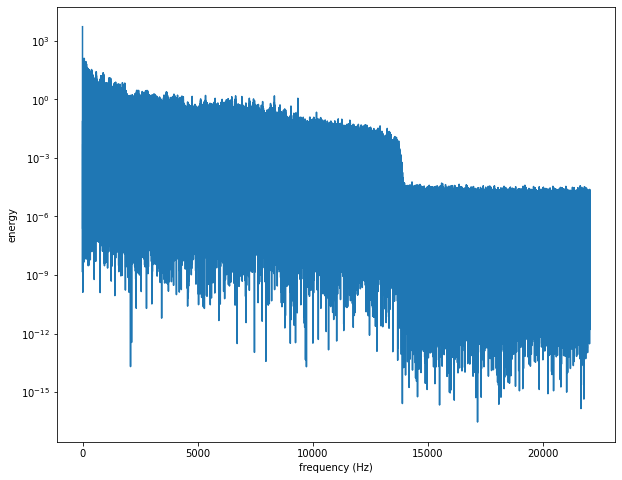

In [3]:
audio_arr, audio_sr = load_wav_audio("original.wav")
dct_freqs, dct_arr = dct(audio_arr, audio_sr)

plt.figure(figsize=(10,8))
plt.plot(dct_freqs, dct_arr**2)
plt.yscale('log')
plt.xlabel('frequency (Hz)')
plt.ylabel('energy')

### Q2
Based on the DCT plot above, suggest why we often filter out the higher frequencies for typical audio files, as opposed to filtering out the lower frequencies? Do you see a natural cutoff threshold in the plot above?

### Q3
Next, we study the reconstructions produced when we set `frequency_cutoff` to very low values or set `n_quantization_levels` to very low values. Listen to `original.wav`, `reconstruction_1.wav` (with very low frequency cutoff) and `reconstruction_2.wav` (with very low number of quantization levels). Describe how the reconstructions sound and explain why based on your understanding of the lossy compression procedure. The last 10 seconds of the audio include higher pitched singing which might be handy to listen to.

In [4]:
reconstructed_audio, bitrate_kpbs, mse = \
    evaluate_dct_lowpass_quantization(audio_arr, audio_sr, frequency_cutoff=1000, n_quantization_levels=2048)
save_wav_audio("reconstruction_1.wav", reconstructed_audio, audio_sr)

In [5]:
reconstructed_audio, bitrate_kpbs, mse = \
    evaluate_dct_lowpass_quantization(audio_arr, audio_sr, frequency_cutoff=20000, n_quantization_levels=128)
save_wav_audio("reconstruction_2.wav", reconstructed_audio, audio_sr)

### Rate-distortion curve
Now we do a sweep of frequency cutoffs and number of quantization levels to get the rate distortion curve achieved by this simple procedure (note that the true optimal R-D curve will lie below).

In [6]:
df = {'bitrate_kbps': [], 'mse': [], 'frequency_cutoff': [], 'n_quantization_levels': []}

for frequency_cutoff in [2000, 4000, 8000, 14000, 20000]:
    for n_quantization_levels in [256, 512, 1024, 2048, 4096]:
        quantized_lowpassed_dct, bitrate_kpbs, mse = evaluate_dct_lowpass_quantization(audio_arr, audio_sr, frequency_cutoff=frequency_cutoff, n_quantization_levels=n_quantization_levels)
        df['bitrate_kbps'].append(bitrate_kpbs)
        df['mse'].append(mse)
        df['frequency_cutoff'].append(frequency_cutoff)
        df['n_quantization_levels'].append(n_quantization_levels)
df = pd.DataFrame(df)

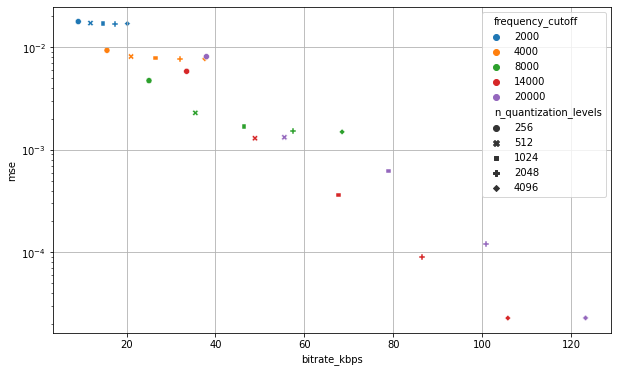

In [7]:
plt.figure(figsize=(10,6))
splot = sns.scatterplot(df, x="bitrate_kbps", y="mse", style="n_quantization_levels", hue="frequency_cutoff", palette="tab10")
splot.set(yscale="log")
plt.grid()

### Q4
Based on the plot above, which parameter (`frequency_cutoff` vs. `n_quantization_levels`) should you tweak to stay on the pareto optimal rate-distortion tradeoff in:
1. low bitrate regime (around 10-30 kpbs)
2. high bitrate regime (around 60-100 kbps)

More generally, whenever we have multiple parameters controlling the rate-distortion tradeoff, we might need to suitably tweak one of them to stay on the optimal curve around any given bitrate. We'll talk about this in the context of videos, and you can read more at https://netflixtechblog.com/per-title-encode-optimization-7e99442b62a2.

----
Your friend who is new to audio compression decides to try something simpler. Instead of working in the transform domain, they decide to simply quantize the original audio signal. 

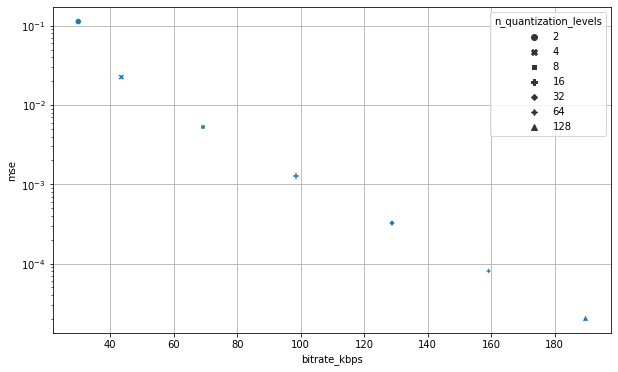

In [8]:
def evaluate_direct_quantization(audio_arr, audio_sr, n_quantization_levels):
    quantized_original_audio, limits = quantize(audio_arr, n_quantization_levels)
    reconstructed_audio_arr = unquantize(quantized_original_audio, n_quantization_levels, limits)
    entropy = compute_entropy(quantized_original_audio)
    bitrate_kbps = entropy*len(quantized_original_audio)/len(audio_arr)*audio_sr/1000
    mse = compute_mse(audio_arr, reconstructed_audio_arr)
    return reconstructed_audio_arr, bitrate_kbps, mse

df = {'bitrate_kbps': [], 'mse': [], 'n_quantization_levels': []}

for n_quantization_levels in [2, 4, 8, 16, 32, 64, 128]:
    quantized_lowpassed_dct, bitrate_kpbs, mse = evaluate_direct_quantization(audio_arr, audio_sr, n_quantization_levels=n_quantization_levels)
    df['bitrate_kbps'].append(bitrate_kpbs)
    df['mse'].append(mse)
    df['n_quantization_levels'].append(n_quantization_levels)
df = pd.DataFrame(df)

plt.figure(figsize=(10,6))
splot = sns.scatterplot(df, x="bitrate_kbps", y="mse", style="n_quantization_levels")
splot.set(yscale="log")
plt.grid()

### Q5
Look at the rate distortion plot above. How does the simpler strategy compare to the transform domain based compressor? Explain why one strategy outperforms the other. You can also listen to two reconstructions below (`reconstruction_3.wav` and `reconstruction_4.wav`) with similar MSE to get a sense of the reconstruction quality.

In [9]:
reconstructed_audio, bitrate_kpbs, mse = \
    evaluate_dct_lowpass_quantization(audio_arr, audio_sr, frequency_cutoff=14000, n_quantization_levels=512)
save_wav_audio("reconstruction_3.wav", reconstructed_audio, audio_sr)
print("reconstruction_3.wav with evaluate_dct_lowpass_quantization")
print(f"mse: {mse}")
print(f"bitrate_kpbs: {bitrate_kpbs}")

print()
reconstructed_audio, bitrate_kpbs, mse = \
    evaluate_direct_quantization(audio_arr, audio_sr, n_quantization_levels=16)
save_wav_audio("reconstruction_4.wav", reconstructed_audio, audio_sr)
print("reconstruction_4.wav with evaluate_direct_quantization")
print(f"mse: {mse}")
print(f"bitrate_kpbs: {bitrate_kpbs}")

reconstruction_3.wav with evaluate_dct_lowpass_quantization
mse: 0.0012973882550256545
bitrate_kpbs: 48.88585046547497

reconstruction_4.wav with evaluate_direct_quantization
mse: 0.001282661590379548
bitrate_kpbs: 98.52557737072262


### Q6
Compare `reconstruction_3.wav` with `reconstruction_48kbps.mp3` which have the same bitrate. You should observe that the mp3 has better quality. Can you suggest at least 2 inefficiencies in our simplistic transform-based codec, and explain how these can be improved upon? As a hint you can read again the description of the method pasted below with certain portions highlighted.

> We work with a simple audio compressor that first computes the DCT **of the entire audio signal at once**, then filters out (**sets to zero**) all frequencies above a cutoff (parameter: `frequency_cutoff`). The remaining DCT values are then **uniform scalar quantized** into a certain number of levels (parameter: `n_quantization_levels`). Finally we simply compute the empirical entropy of the quantized truncated DCT to get an estimate of the compression rate when we apply Huffman coding or **0th order** arithmetic coding. 
